# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Electron'

data_path = "data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [19]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [20]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [21]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [22]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [23]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [24]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv")

In [26]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [27]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [4]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [5]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [6]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Train XGBoost

In [29]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.0470898 ,  0.07890646,  0.41969519])

In [30]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.0470898
Weight of class 1 is  0.419695187166
Weight of class 2 is  0.0789064646939
Weight of class 3 is  0.0470898
Weight of class 4 is  0.0470898
Weight of class 5 is  0.0470898


In [11]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [12]:
%%time
clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 50,
                        features=features)

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

CPU times: user 2h 28min 17s, sys: 6.73 s, total: 2h 28min 24s
Wall time: 38min 19s


# Save the classifier

In [13]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [14]:
new_work_path = work_path + "/" + params_str + 'balanced_data_' + str(len(data))
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;balanced_data_235449'

In [15]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

# clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
# pickle.dump(clf, clf_pickle)
# clf_pickle.close()

In [7]:
new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;\
n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;\
balanced_data_235449"

In [8]:
# Read classifier
clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
clf = pickle.load(clf_pickle2)
clf_pickle2.close()

# Test the classifier

In [16]:
probas = clf.predict_proba(data.loc[test_inds])

In [17]:
probas[:5, :]

array([[  4.62493785e-02,   9.23532248e-03,   5.32213449e-02,
          4.12242532e-01,   2.00672314e-01,   2.78379083e-01],
       [  6.57152012e-03,   1.53007433e-02,   2.80926321e-02,
          4.89158221e-02,   3.79388571e-01,   5.21730721e-01],
       [  2.20126197e-01,   6.81018382e-02,   1.16915023e-02,
          6.89650178e-02,   3.29422385e-01,   3.01693052e-01],
       [  5.96558392e-01,   3.94641399e-01,   1.29669532e-03,
          2.99562165e-03,   2.11925013e-03,   2.38865474e-03],
       [  3.50153400e-03,   3.29533534e-04,   4.06518142e-04,
          9.94115353e-01,   7.92873790e-04,   8.54128913e-04]], dtype=float32)

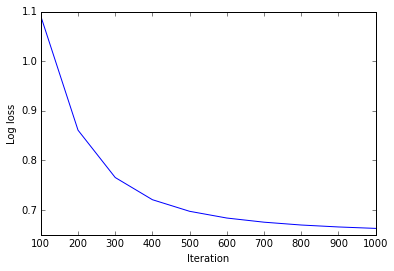

In [18]:
step = clf.get_params()['n_estimators'] / 10
staged_probas = clf.staged_predict_proba(data.loc[test_inds], step=step)

from sklearn.metrics import log_loss
log_loss_all = []
for pred in staged_probas:
    log_loss_all.append(log_loss(labels_test, pred))

x = numpy.arange(step, clf.get_params()['n_estimators'] + step, step)
plt.plot(x, log_loss_all)
plt.ylabel('Log loss')
plt.xlabel('Iteration')
plt.show()

### Logloss

In [19]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.6629206893577041

### Roc curves

In [20]:
import os, sys
sys.path.append('../python')
import utils

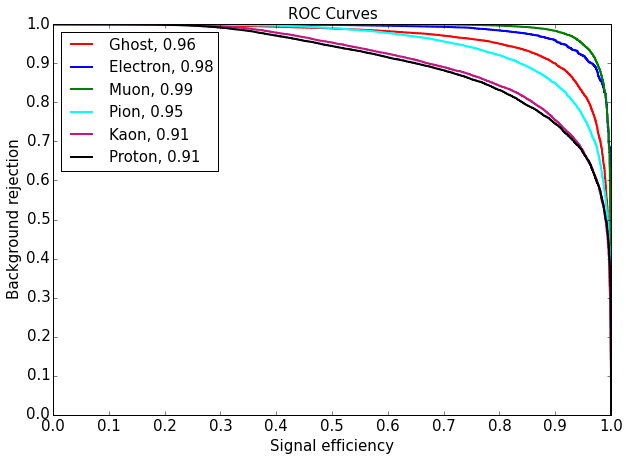

In [21]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [9]:
import os, sys
sys.path.append('../python')
import utils

In [10]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [11]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [12]:
proba_eval = clf.predict_proba(data_eval)

In [13]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [14]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [15]:
proba_eval[:5, :]

array([[  3.27386498e-03,   5.10506285e-03,   5.92217408e-03,
          9.88489576e-03,   1.39659718e-01,   8.36154282e-01],
       [  4.04517446e-03,   1.44393696e-03,   8.75669648e-04,
          1.60031114e-03,   4.67734993e-01,   5.24299920e-01],
       [  1.21697681e-02,   1.33436639e-03,   2.96366680e-03,
          9.62604702e-01,   1.07505275e-02,   1.01769678e-02],
       [  2.83747077e-01,   1.07487649e-01,   6.15674490e-03,
          4.27590102e-01,   7.64620006e-02,   9.85564515e-02],
       [  9.11287963e-03,   1.19980343e-03,   5.71296026e-04,
          9.87301350e-01,   9.08022223e-04,   9.06683563e-04]], dtype=float32)

### Get all figures from baseline

In [18]:
from get_figures import all_figures

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [34]:
from sklearn.metrics import log_loss

logloss = log_loss(labels_eval, proba_eval)
numpy.savetxt(new_work_path + '/logloss_eval.csv', [logloss])
logloss

0.67020710574309172

### Roc curves, roc auc matrix and roc auc ratio matrix

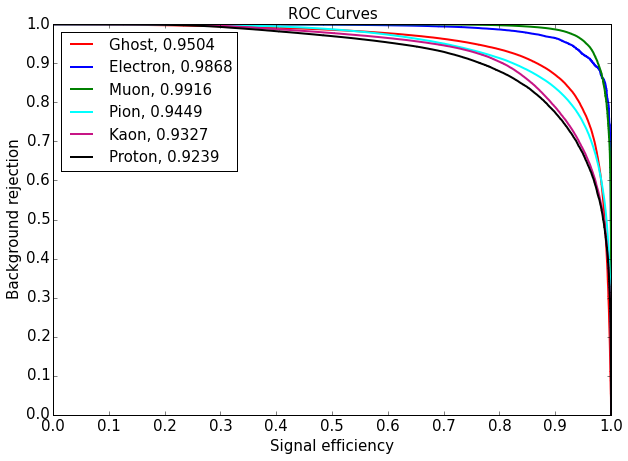

In [15]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

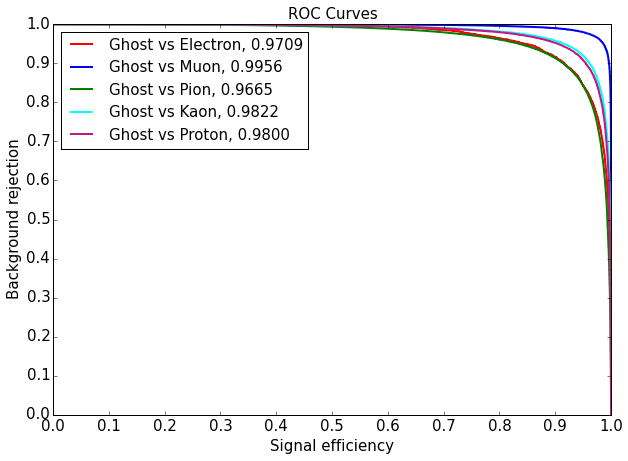

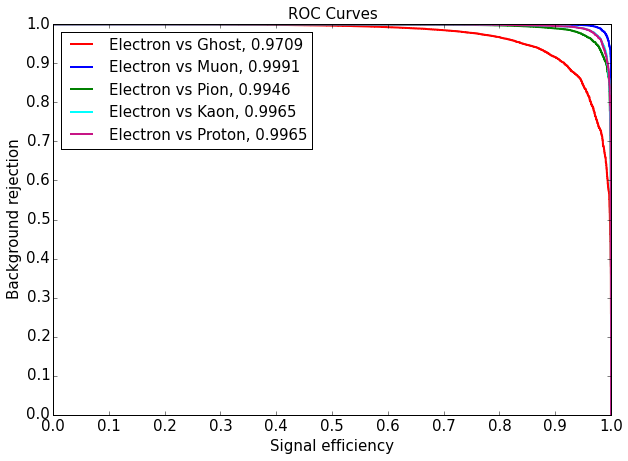

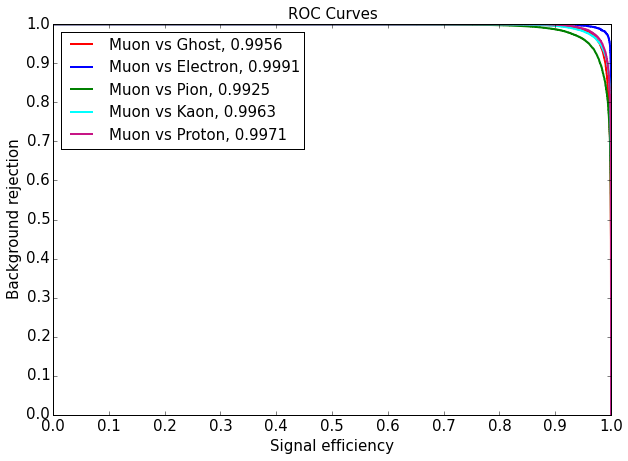

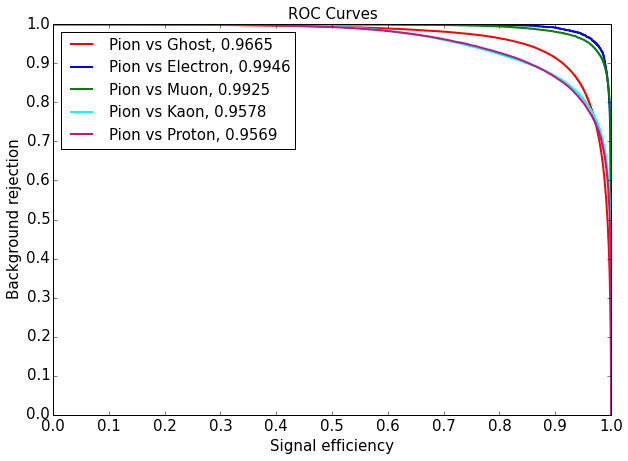

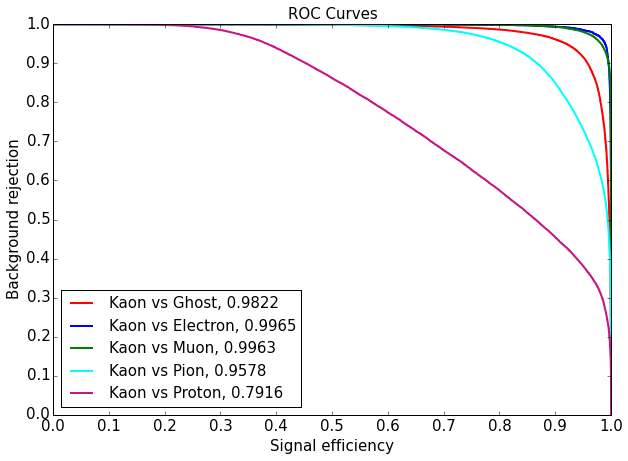

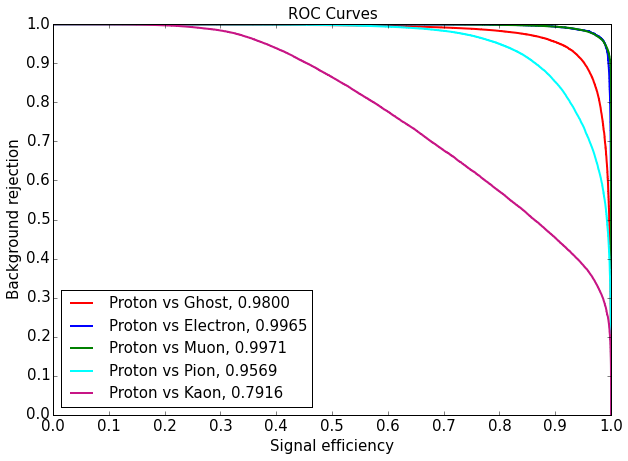

In [17]:
utils.get_one_vs_one_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

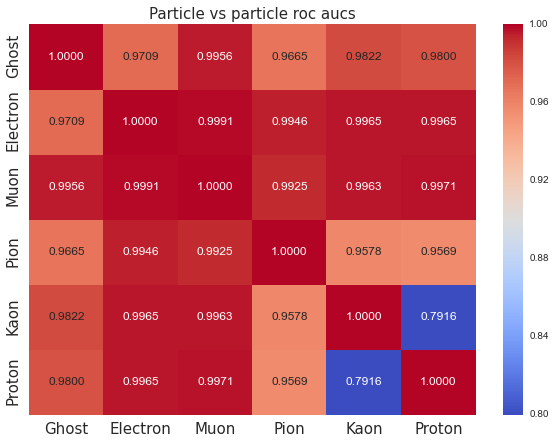

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.970859,0.995642,0.966467,0.982237,0.980027
Electron,0.970859,1.000000,0.999130,0.994635,0.996546,0.996521
Muon,0.995642,0.999130,1.000000,0.992478,0.996332,0.997118
Pion,0.966467,0.994635,0.992478,1.000000,0.957833,0.956949
Kaon,0.982237,0.996546,0.996332,0.957833,1.000000,0.791571
Proton,0.980027,0.996521,0.997118,0.956949,0.791571,1.000000


In [16]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [17]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

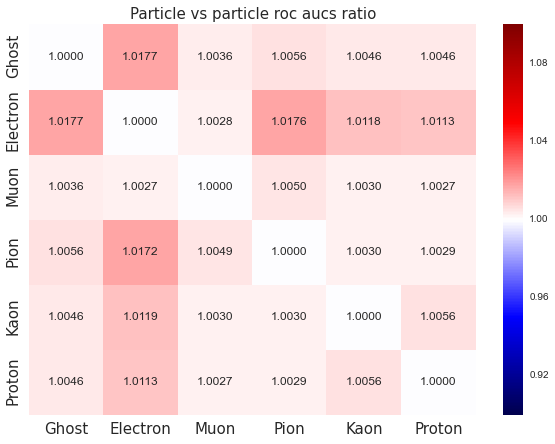

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,1.017723,1.003555,1.005613,1.004625,1.004627
Electron,1.017724,1.000000,1.002752,1.017580,1.011840,1.011337
Muon,1.003555,1.002749,1.000000,1.004967,1.002973,1.002660
Pion,1.005613,1.017247,1.004941,1.000000,1.003034,1.002924
Kaon,1.004625,1.011874,1.002973,1.003034,1.000000,1.005591
Proton,1.004627,1.011332,1.002660,1.002923,1.005591,1.000000


In [18]:
utils.get_roc_auc_ratio_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

### Flatness

In [14]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

CPU times: user 9min 27s, sys: 7.91 s, total: 9min 35s
Wall time: 10min 8s


In [15]:
flatness

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Ghost,0.004460,0.013263,0.000866,0.000867
Electron,0.008164,0.031106,0.000991,0.000989
Muon,0.030727,0.042916,0.000891,0.000886
Pion,0.017987,0.014955,0.000853,0.000854
Kaon,0.048014,0.033361,0.000876,0.000885
Proton,0.038002,0.046015,0.000893,0.000879


In [16]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv", index_col=0)
flatness_baseline

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Electron,0.006546,0.016579,0.001014,0.001004
Proton,0.034632,0.044571,0.000886,0.000888
Pion,0.016512,0.013729,0.000853,0.000851
Muon,0.020388,0.044991,0.000905,0.000906
Kaon,0.043074,0.036657,0.000872,0.000880
Ghost,0.006591,0.014187,0.000871,0.000870


In [17]:
utils.get_flatness_ratio(flatness, flatness_baseline, save_path=new_work_path)

,TrackP,TrackPt
Ghost,0.676703,0.934865
Electron,1.247104,1.876186
Muon,1.507104,0.953887
Pion,1.089310,1.089343
Kaon,1.114706,0.910092
Proton,1.097296,1.032387


### Efficiency curves

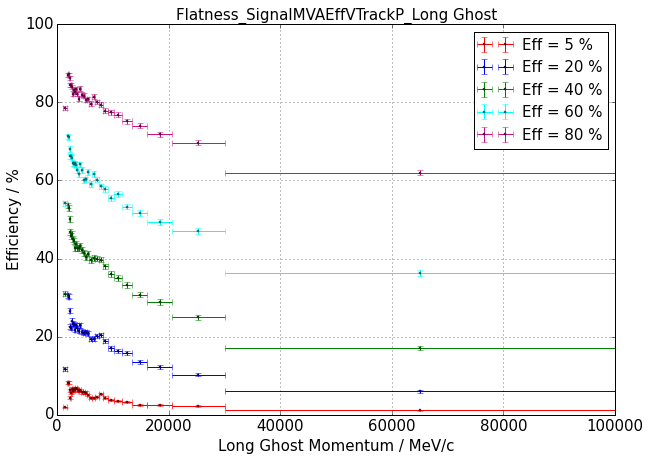

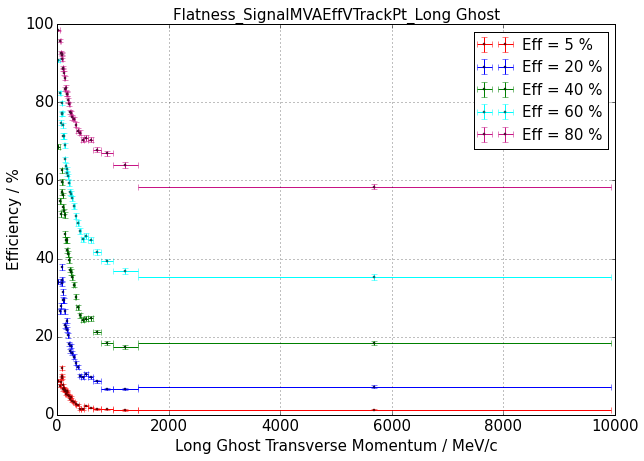

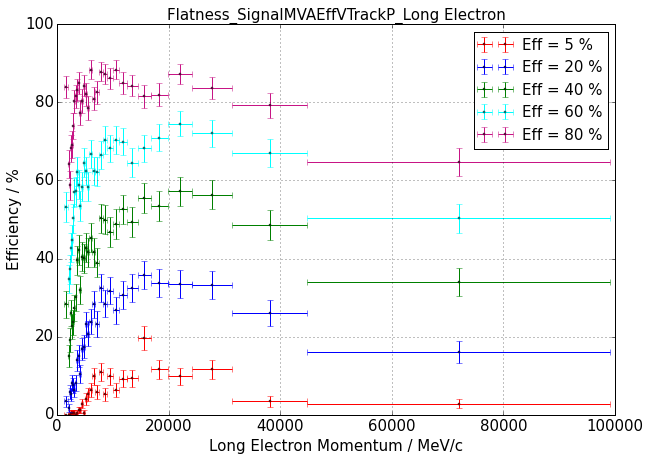

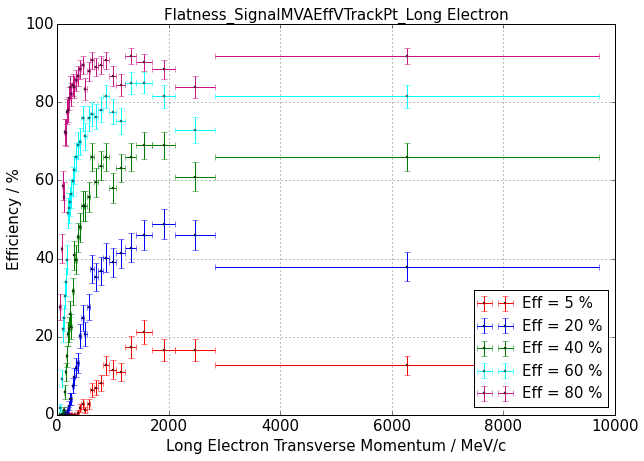

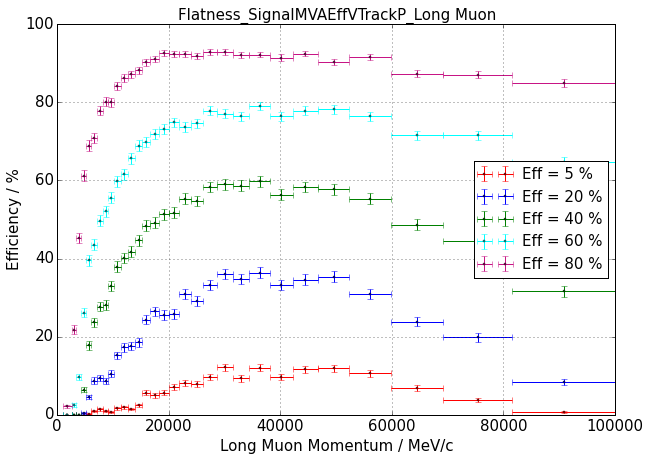

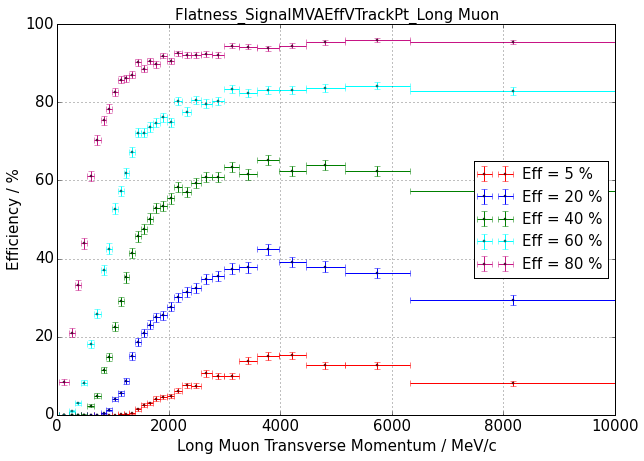

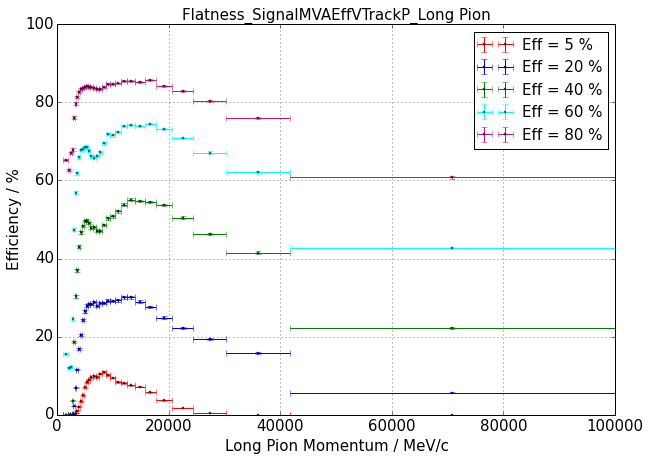

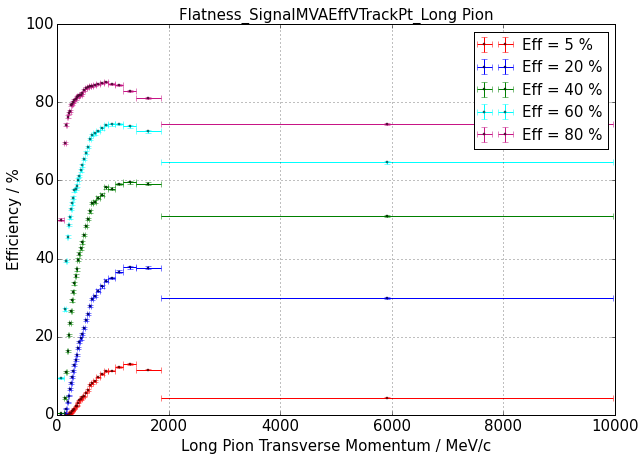

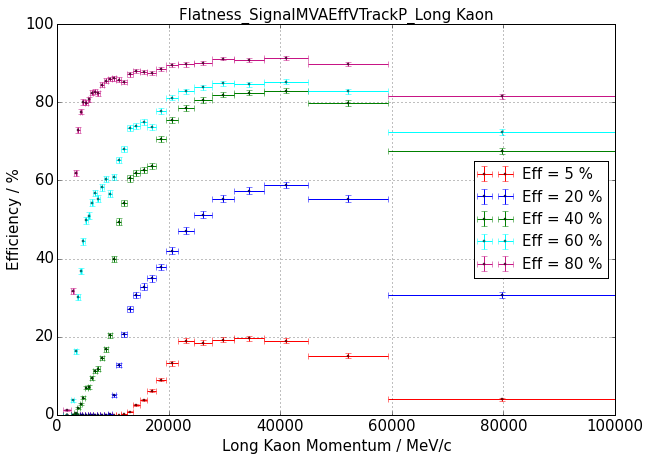

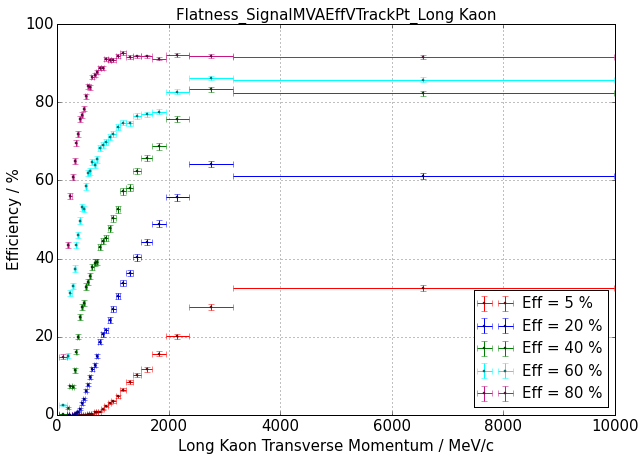

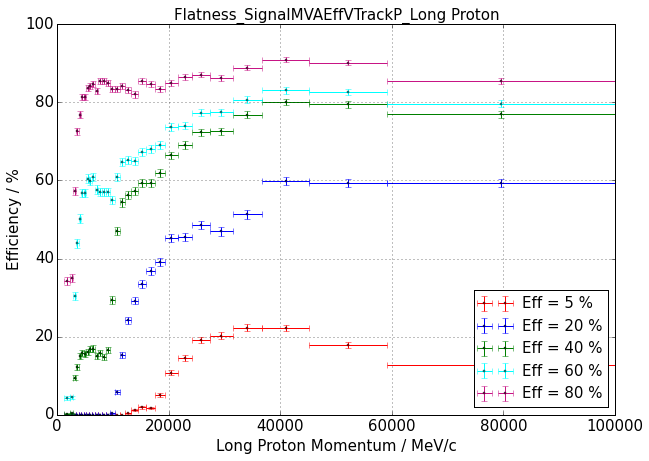

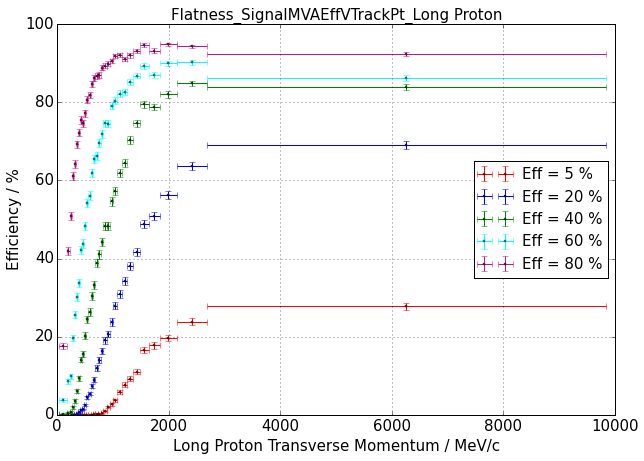

In [31]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)